# 00_benchmark con Tensorflow - Números de casas en color

El objetivo de este ejemplo es
- leer el dataset
- construir una NN basica de 2 capas ocultas 
- ejecutar el proceso de clasificación multi-class
- obtener el error al final
- graficar su evolución

In [1]:
from __future__ import print_function, division
from builtins import range

import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from scipy.io import loadmat
from sklearn.utils import shuffle
from datetime import datetime

In [2]:
def y2indicator(y):
    N = len(y)
    ind = np.zeros((N, 10))
    for i in range(N):
        ind[i, y[i]] = 1
    return ind

In [3]:
def error_rate(p, t):
    return np.mean(p != t)

In [4]:
# Función para 'aplanar' la entrada matricial de los MNIST
def flatten(X):
    # input will be (32, 32, 3, N)
    # output will be (N, 3072)
    N = X.shape[-1]
    flat = np.zeros((N, 3072))
    for i in range(N):
        flat[i] = X[:,:,:,i].reshape(3072)
    return flat

In [5]:
# Leemos los datos...
def get_data():
    train = loadmat('/home/jorge/data/house_numbers/train_32x32.mat')
    test  = loadmat('/home/jorge/data/house_numbers/test_32x32.mat')
    return train, test

## Proceso

In [6]:
# leemos los datos
train, test = get_data()

In [7]:
# Es necesario escalar los datos! No pueden quedar como 0..255
# Y es una matriz de N x 1 con valores 1..10 (MATLAB indexa desde 1)

# aplanamos las etiquetas y los pasamos a 0..9
# Tambien necesitamos una matriz de indicadores para el calculo del coste...
Xtrain = flatten(train['X'].astype(np.float32) / 255)
Ytrain = train['y'].flatten() - 1
Xtrain, Ytrain = shuffle(Xtrain, Ytrain)
Ytrain_ind = y2indicator(Ytrain)

Xtest  = flatten(test['X'].astype(np.float32) / 255)
Ytest  = test['y'].flatten() - 1
Ytest_ind  = y2indicator(Ytest)


In [15]:
# Parametros del Descenso de Gradiente
max_iter = 20
print_period = 500
N, D = Xtrain.shape
batch_sz = 500
n_batches = N / batch_sz

In [16]:
# Pesos iniciales
M1 = 1000 # hidden layer size
M2 = 500
K = 10
W1_init = np.random.randn(D, M1) / np.sqrt(D + M1)
b1_init = np.zeros(M1)
W2_init = np.random.randn(M1, M2) / np.sqrt(M1 + M2)
b2_init = np.zeros(M2)
W3_init = np.random.randn(M2, K) / np.sqrt(M2 + K)
b3_init = np.zeros(K)


In [17]:
# Definimos variables y expresiones para Tensorflow
X = tf.placeholder(tf.float32, shape=(None, D), name='X')
T = tf.placeholder(tf.float32, shape=(None, K), name='T')

W1 = tf.Variable(W1_init.astype(np.float32))
b1 = tf.Variable(b1_init.astype(np.float32))
W2 = tf.Variable(W2_init.astype(np.float32))
b2 = tf.Variable(b2_init.astype(np.float32))
W3 = tf.Variable(W3_init.astype(np.float32))
b3 = tf.Variable(b3_init.astype(np.float32))

Z1 = tf.nn.relu( tf.matmul(X, W1) + b1 )
Z2 = tf.nn.relu( tf.matmul(Z1, W2) + b2 )
Yish = tf.matmul(Z2, W3) + b3

In [18]:
# Definición de la función de coste y el metodo de training
#-----------------------------------------------------------
# Como es una clasificación multiclass usaremos cross_entropy

# tf.reduce_sum
#           https://www.tensorflow.org/api_docs/python/tf/reduce_sum
#           Computes the sum of elements across dimensions of a tensor.

# softmax_cross_entropy_with_logits
#           https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits

#           Computes softmax cross entropy between logits and labels.
#           Measures the probability error in discrete classification tasks in which the classes 
#           are mutually exclusive (each entry is in exactly one class).

cost = tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits(logits=Yish, labels=T))


train_op = tf.train.RMSPropOptimizer(0.0001, decay=0.99, momentum=0.9).minimize(cost)

# Usaremos esto para calcular el error rate
predict_op = tf.argmax(Yish, 1)

LL = []

# Inicializamos las variables
init = tf.global_variables_initializer()


In [19]:
t0 = datetime.now()
with tf.Session() as session:
    session.run(init)

    for i in range(max_iter):
        for j in range(n_batches):
            Xbatch = Xtrain[j*batch_sz:(j*batch_sz + batch_sz),]
            Ybatch = Ytrain_ind[j*batch_sz:(j*batch_sz + batch_sz),]

            session.run(train_op, feed_dict={X: Xbatch, T: Ybatch})
            if j % print_period == 0:
                test_cost = session.run(cost, feed_dict={X: Xtest, T: Ytest_ind})
                prediction = session.run(predict_op, feed_dict={X: Xtest})
                err = error_rate(prediction, Ytest)
                print("Coste / error en la iteracion i=%d, j=%d: %.3f / %.3f" % (i, j, test_cost, err))
                LL.append(test_cost)
print("Tiempo transcurrido:", (datetime.now() - t0))


Coste / error en la iteracion i=0, j=0: 58444.184 / 0.804
Coste / error en la iteracion i=1, j=0: 44356.594 / 0.580
Coste / error en la iteracion i=2, j=0: 35142.422 / 0.423
Coste / error en la iteracion i=3, j=0: 30564.457 / 0.356
Coste / error en la iteracion i=4, j=0: 28648.350 / 0.330
Coste / error en la iteracion i=5, j=0: 26665.977 / 0.308
Coste / error en la iteracion i=6, j=0: 25359.285 / 0.291
Coste / error en la iteracion i=7, j=0: 24467.525 / 0.280
Coste / error en la iteracion i=8, j=0: 23406.654 / 0.265
Coste / error en la iteracion i=9, j=0: 22511.945 / 0.253
Coste / error en la iteracion i=10, j=0: 21931.184 / 0.245
Coste / error en la iteracion i=11, j=0: 22081.043 / 0.248
Coste / error en la iteracion i=12, j=0: 21764.707 / 0.243
Coste / error en la iteracion i=13, j=0: 21638.279 / 0.237
Coste / error en la iteracion i=14, j=0: 21089.480 / 0.234
Coste / error en la iteracion i=15, j=0: 20044.309 / 0.220
Coste / error en la iteracion i=16, j=0: 19988.410 / 0.218
Coste /

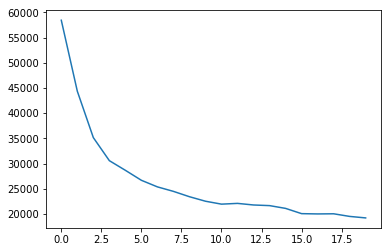

In [20]:
plt.plot(LL)
plt.show()